# SARIMAX with monthly data

In [1]:
#import of the neccessary libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from ftplib import FTP
import os
import warnings
from datetime import datetime
from dateutil.relativedelta import relativedelta
from sklearn.metrics import mean_squared_error, mean_absolute_error

from statsmodels.tsa.stattools import adfuller,kpss

import statsmodels.api as sm
import matplotlib
import pmdarima as pm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pylab import rcParams
import itertools

warnings.filterwarnings('ignore')

<AxesSubplot:xlabel='date'>

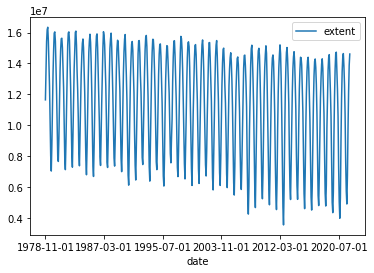

In [2]:
df_month_ext = pd.read_csv('../data/N_monthly.csv')
df_month_ext.plot(x='date', y='extent')

In [3]:
df_month_mod = df_month_ext[['date','extent']]
df_month_mod['date'] = pd.to_datetime(df_month_mod['date'])

ADF Test:
Null Hypothesis: Not Stationary
ADF Statistic: -1.304730
p-value: 0.627005
----------------------------------------
KPSS Test:
Null Hypothesis: Stationary
KPSS Statistic: 1.697406
p-value: 0.010000
----------------------------------------


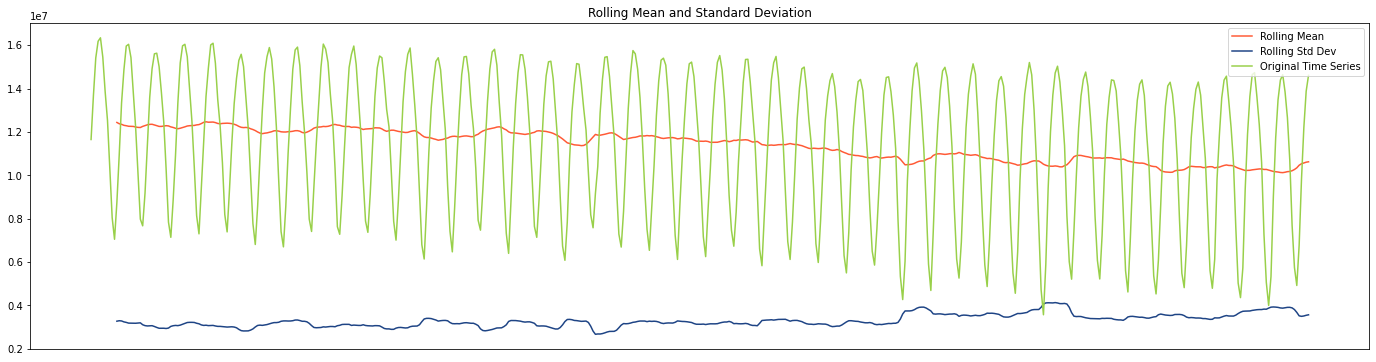

In [4]:
# checking for stationarity 

def stationarity_test(extent, t):
    
    # Calculate rolling mean and rolling standard deviation
    rolling_mean = extent.rolling(t).mean()
    rolling_std_dev = extent.rolling(t).std()
    
    # Plot the statistics
    plt.figure(figsize=(24,6))
    plt.plot(rolling_mean, color='#FF5A36', label='Rolling Mean')
    plt.plot(rolling_std_dev, color='#1E4485', label = 'Rolling Std Dev')
    plt.plot(extent, color='#99D04A',label='Original Time Series')
    plt.xticks([])
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    
    # ADF test
    print("ADF Test:")
    adf_test = adfuller(extent,autolag='AIC')
    print('Null Hypothesis: Not Stationary')
    print('ADF Statistic: %f' % adf_test[0])
    print('p-value: %f' % adf_test[1])
    print('----'*10)
    
    # KPSS test
    print("KPSS Test:")
    kpss_test = kpss(extent, regression='c', nlags="legacy", store=False)
    print('Null Hypothesis: Stationary')
    print('KPSS Statistic: %f' % kpss_test[0])
    print('p-value: %f' % kpss_test[1])
    print('----'*10)
stationarity_test(df_month_ext['extent'],12)

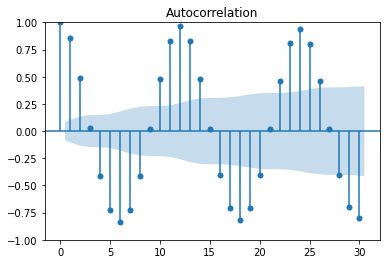

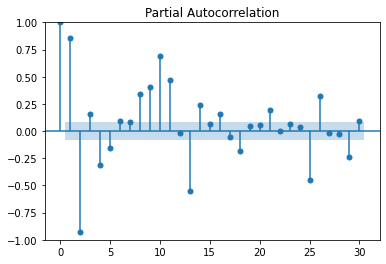

In [5]:
plot_acf(df_month_ext['extent'], lags=30)
plt.show()
plot_pacf(df_month_ext['extent'], lags=30)
plt.show()

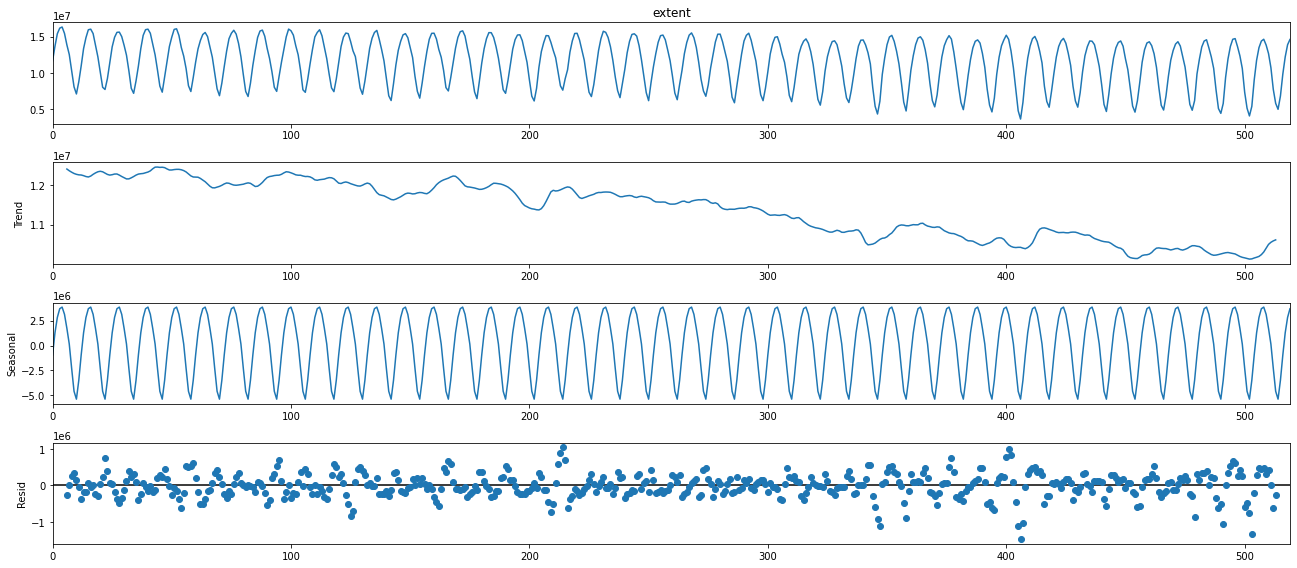

In [6]:
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(df_month_mod['extent'], model='additive', period=12)
fig = decomposition.plot()
plt.show()

In [7]:
# split into train and test sets (we use the last five years as test-data)

X_month = df_month_mod['extent']

train_size = int(len(X_month)*0.881)
train_month, test_month = X_month[1:train_size], X_month[train_size:]

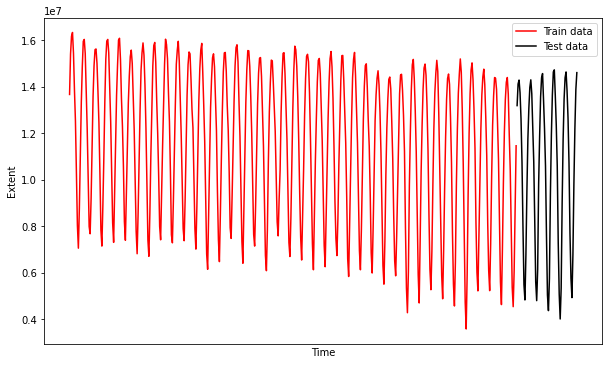

In [8]:
# Plotting the train and test set

plt.figure(figsize=(10,6))
plt.xlabel('Time')
plt.ylabel('Extent')
plt.xticks([])
plt.plot(train_month, 'red', label='Train data')
plt.plot(test_month, 'black', label='Test data')
plt.legend();

In [9]:
# grid search sarima hyperparameters for monthly car sales dataset
from math import sqrt
from multiprocessing import cpu_count
from joblib import Parallel
from joblib import delayed

 
# one-step sarima forecast
def sarima_forecast(history, config):
	order, sorder, trend = config
	# define model
	model = SARIMAX(history, order=order, seasonal_order=sorder, trend=trend, enforce_stationarity=False, enforce_invertibility=False)
	# fit model
	model_fit = model.fit(disp=False)
	# make one step forecast
	yhat = model_fit.predict(len(history), len(history))
	return yhat[0]
 
# root mean squared error or rmse
def measure_rmse(actual, predicted):
	return sqrt(mean_squared_error(actual, predicted))
 
# split a univariate dataset into train/test sets
def train_test_split(data, n_test):
	return data[:-n_test], data[-n_test:]
 
# walk-forward validation for univariate data
def walk_forward_validation(data, n_test, cfg):
	predictions = list()
	# split dataset
	train, test = train_test_split(data, n_test)
	# seed history with training dataset
	history = [x for x in train]
	# step over each time-step in the test set
	for i in range(len(test)):
		# fit model and make forecast for history
		yhat = sarima_forecast(history, cfg)
		# store forecast in list of predictions
		predictions.append(yhat)
		# add actual observation to history for the next loop
		history.append(test[i])
	# estimate prediction error
	error = measure_rmse(test, predictions)
	return error
 
# score a model, return None on failure
def score_model(data, n_test, cfg, debug=False):
	result = None
	# convert config to a key
	key = str(cfg)
	# show all warnings and fail on exception if debugging
	if debug:
		result = walk_forward_validation(data, n_test, cfg)
	else:
		# one failure during model validation suggests an unstable config
		try:
			# never show warnings when grid searching, too noisy
			with catch_warnings():
				filterwarnings("ignore")
				result = walk_forward_validation(data, n_test, cfg)
		except:
			error = None
	# check for an interesting result
	if result is not None:
		print(' > Model[%s] %.3f' % (key, result))
	return (key, result)
 
# grid search configs
def grid_search(data, cfg_list, n_test, parallel=True):
	scores = None
	if parallel:
		# execute configs in parallel
		executor = Parallel(n_jobs=cpu_count(), backend='multiprocessing')
		tasks = (delayed(score_model)(data, n_test, cfg) for cfg in cfg_list)
		scores = executor(tasks)
	else:
		scores = [score_model(data, n_test, cfg) for cfg in cfg_list]
	# remove empty results
	scores = [r for r in scores if r[1] != None]
	# sort configs by error, asc
	scores.sort(key=lambda tup: tup[1])
	return scores
 
# create a set of sarima configs to try
def sarima_configs(seasonal=[0]):
	models = list()
	# define config lists
	p_params = [0, 1, 2]
	d_params = [0, 1]
	q_params = [0, 1, 2]
	t_params = ['t','ct']
	P_params = [0, 1, 2]
	D_params = [0, 1]
	Q_params = [0, 1, 2]
	m_params = seasonal
	# create config instances
	for p in p_params:
		for d in d_params:
			for q in q_params:
				for t in t_params:
					for P in P_params:
						for D in D_params:
							for Q in Q_params:
								for m in m_params:
									cfg = [(p,d,q), (P,D,Q,m), t]
									models.append(cfg)
	return models
 

In [10]:
# split into train and test sets (we use the last five years as test-data)

X_month = df_month_mod['extent']

train_size = int(len(X_month)*0.881)
train_month, test_month = X_month[1:train_size], X_month[train_size:]
print('Observations: %d' % (len(X_month)))
print('Training Observations: %d' % (len(train_month)))
print('Testing Observations: %d' % (len(test_month)))

Observations: 520
Training Observations: 457
Testing Observations: 62


In [11]:
#import itertools

p = range(0, 3)
d = range(1,2)
q = range(0, 3)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(train_month,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit()
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 1, 1) x (0, 1, 1, 12)
SARIMAX: (0, 1, 1) x (0, 1, 2, 12)
SARIMAX: (0, 1, 2) x (1, 1, 0, 12)
SARIMAX: (0, 1, 2) x (1, 1, 1, 12)
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.37207D+01    |proj g|=  8.88177D-08

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      0      1      0     0     0   8.882D-08   1.372D+01
  F =   13.720749546982301     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL          

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.33323D+01    |proj g|=  6.40476D+00


 This problem is unconstrained.



At iterate    5    f=  1.27988D+01    |proj g|=  5.18013D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      9     13      1     0     0   7.124D-06   1.280D+01
  F =   12.796969617842738     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(0, 1, 0)x(0, 1, 2, 12)12 - AIC:11702.430230708262
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.32221D+01    |proj g|=  6.58336D-06

           * * *

Tit   = total number of iterations
Tnf   = total number o

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  1.31758D+01    |proj g|=  1.48576D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      6      9      1     0     0   1.609D-06   1.318D+01
  F =   13.175811957747079     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(0, 1, 0)x(1, 1, 1, 12)12 - AIC:12048.69212938083


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.32862D+01    |proj g|=  3.51548D+00

At iterate    5    f=  1.28169D+01    |proj g|=  6.51476D-02

At iterate   10    f=  1.27926D+01    |proj g|=  2.73336D-02

At iterate   15    f=  1.27921D+01    |proj g|=  1.30106D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     15     20      1     0     0   1.301D-05   1.279D+01
  F =   12.792139249690631     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(0,

 This problem is unconstrained.


ARIMA(0, 1, 0)x(2, 1, 0, 12)12 - AIC:11731.300568823395
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.28254D+01    |proj g|=  1.57345D-02


 This problem is unconstrained.



At iterate    5    f=  1.28246D+01    |proj g|=  1.31071D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      6      9      1     0     0   1.796D-06   1.282D+01
  F =   12.824615004681595     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(0, 1, 0)x(2, 1, 1, 12)12 - AIC:11729.698114278977
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.31939D+01    |proj g|=  2.83394D+00


 This problem is unconstrained.



At iterate    5    f=  1.27965D+01    |proj g|=  1.37035D-02

At iterate   10    f=  1.27931D+01    |proj g|=  2.14192D-02

At iterate   15    f=  1.27904D+01    |proj g|=  5.89537D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     18     29      1     0     0   7.772D-05   1.279D+01
  F =   12.790376430846006     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(0, 1, 0)x(2, 1, 2, 12)12 - AIC:11700.40405779325
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  1.32046D+01    |proj g|=  7.68300D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      8     10      1     0     0   7.576D-07   1.320D+01
  F =   13.204539271069038     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(0, 1, 1)x(0, 1, 1, 12)12 - AIC:12074.9488937571


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.32102D+01    |proj g|=  4.97139D+00

At iterate    5    f=  1.27947D+01    |proj g|=  4.88696D-02

At iterate   10    f=  1.27938D+01    |proj g|=  2.07569D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     11     16      1     0     0   7.497D-06   1.279D+01
  F =   12.793846908544497     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(0, 1, 1)x(0, 1, 2, 12)12 - AIC:11701.57607440967
RUNNING THE L-B

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  1.31729D+01    |proj g|=  8.54081D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      8     11      1     0     0   5.867D-06   1.317D+01
  F =   13.172876507566246     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(0, 1, 1)x(1, 1, 1, 12)12 - AIC:12048.009127915548
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.31099D+01    |proj g|=  2.24202D+00


 This problem is unconstrained.



At iterate    5    f=  1.28092D+01    |proj g|=  4.15028D-02

At iterate   10    f=  1.27942D+01    |proj g|=  1.95855D-02

At iterate   15    f=  1.27938D+01    |proj g|=  5.06141D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     17     22      1     0     0   1.403D-06   1.279D+01
  F =   12.793820292436600     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(0, 1, 1)x(1, 1, 2, 12)12 - AIC:11703.551747287052
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate   

 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      4      8      1     0     0   8.814D-07   1.286D+01
  F =   12.859633193507527     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(0, 1, 1)x(2, 1, 0, 12)12 - AIC:11761.70473886588
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.28577D+01    |proj g|=  1.16353D-02


 This problem is unconstrained.



At iterate    5    f=  1.28570D+01    |proj g|=  2.56989D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      8     12      1     0     0   3.128D-06   1.286D+01
  F =   12.857007034348397     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(0, 1, 1)x(2, 1, 1, 12)12 - AIC:11761.304429394435
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.30508D+01    |proj g|=  1.80493D+00


 This problem is unconstrained.



At iterate    5    f=  1.27968D+01    |proj g|=  8.96910D-03

At iterate   10    f=  1.27946D+01    |proj g|=  1.23491D-02

At iterate   15    f=  1.27930D+01    |proj g|=  7.53385D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     18     23      1     0     0   4.623D-06   1.279D+01
  F =   12.792951259476030     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(0, 1, 1)x(2, 1, 2, 12)12 - AIC:11704.757451161091
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate   

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  1.31421D+01    |proj g|=  7.99986D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      8     10      1     0     0   7.609D-06   1.314D+01
  F =   13.142069108795248     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(0, 1, 2)x(0, 1, 1, 12)12 - AIC:12019.851165438857
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.31706D+01    |proj g|=  5.29034D+00


 This problem is unconstrained.



At iterate    5    f=  1.27318D+01    |proj g|=  5.43285D-02

At iterate   10    f=  1.27289D+01    |proj g|=  4.58101D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     12     16      1     0     0   9.660D-07   1.273D+01
  F =   12.728903896882130     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(0, 1, 2)x(0, 1, 2, 12)12 - AIC:11644.218161750267
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.32247D+01    |proj g|=  4.98770D-02

At iterate   

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.31325D+01    |proj g|=  3.34507D-01

At iterate    5    f=  1.31096D+01    |proj g|=  6.20412D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      8     11      1     0     0   2.556D-05   1.311D+01
  F =   13.109636408016989     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(0, 1, 2)x(1, 1, 1, 12)12 - AIC:11992.207676927528


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.30640D+01    |proj g|=  2.39823D+00

At iterate    5    f=  1.27439D+01    |proj g|=  5.97659D-02

At iterate   10    f=  1.27293D+01    |proj g|=  1.75324D-02

At iterate   15    f=  1.27289D+01    |proj g|=  8.44591D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     17     21      1     0     0   4.260D-05   1.273D+01
  F =   12.728856528246704     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(0,

 This problem is unconstrained.



At iterate    5    f=  1.28283D+01    |proj g|=  3.77430D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      5     10      1     0     0   3.774D-05   1.283D+01
  F =   12.828337358776412     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(0, 1, 2)x(2, 1, 0, 12)12 - AIC:11735.10034592164
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.28270D+01    |proj g|=  2.11958D-02


 This problem is unconstrained.



At iterate    5    f=  1.28249D+01    |proj g|=  1.43692D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6      9     14      1     0     0   4.584D-06   1.282D+01
  F =   12.824764275919916     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(0, 1, 2)x(2, 1, 1, 12)12 - AIC:11733.834548190804
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.30010D+01    |proj g|=  1.92919D+00


 This problem is unconstrained.



At iterate    5    f=  1.27317D+01    |proj g|=  8.51934D-03

At iterate   10    f=  1.27308D+01    |proj g|=  1.12828D-02

At iterate   15    f=  1.27282D+01    |proj g|=  4.21609D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     19     26      1     0     0   5.502D-06   1.273D+01
  F =   12.728189789518385     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(0, 1, 2)x(2, 1, 2, 12)12 - AIC:11647.565467619805
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate   

 This problem is unconstrained.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      8     10      1     0     0   1.770D-06   1.323D+01
  F =   13.234388510398684     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(1, 1, 0)x(0, 1, 1, 12)12 - AIC:12102.231098504397
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.32421D+01    |proj g|=  4.99738D+00


 This problem is unconstrained.



At iterate    5    f=  1.28255D+01    |proj g|=  4.19969D-02

At iterate   10    f=  1.28239D+01    |proj g|=  4.19554D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     11     15      1     0     0   9.022D-07   1.282D+01
  F =   12.823900551376093     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(1, 1, 0)x(0, 1, 2, 12)12 - AIC:11729.04510395775
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.32141D+01    |proj g|=  2.96097D-02

           * *

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  1.32031D+01    |proj g|=  9.94833D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      6      9      1     0     0   3.038D-05   1.320D+01
  F =   13.203124027521879     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(1, 1, 0)x(1, 1, 1, 12)12 - AIC:12075.655361154997
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.31411D+01    |proj g|=  2.25423D+00


 This problem is unconstrained.



At iterate    5    f=  1.28396D+01    |proj g|=  4.25235D-02

At iterate   10    f=  1.28242D+01    |proj g|=  1.87020D-02

At iterate   15    f=  1.28239D+01    |proj g|=  3.10514D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     16     21      1     0     0   8.426D-06   1.282D+01
  F =   12.823885729333444     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(1, 1, 0)x(1, 1, 2, 12)12 - AIC:11731.031556610767
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate   

 This problem is unconstrained.


ARIMA(1, 1, 0)x(2, 1, 0, 12)12 - AIC:11732.801290438776
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.28257D+01    |proj g|=  1.51728D-02


 This problem is unconstrained.



At iterate    5    f=  1.28247D+01    |proj g|=  1.21715D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      8     12      1     0     0   1.187D-06   1.282D+01
  F =   12.824660568686859     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(1, 1, 0)x(2, 1, 1, 12)12 - AIC:11731.73975977979
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.30817D+01    |proj g|=  1.81580D+00


 This problem is unconstrained.



At iterate    5    f=  1.28268D+01    |proj g|=  8.78716D-03

At iterate   10    f=  1.28247D+01    |proj g|=  1.20896D-02

At iterate   15    f=  1.28230D+01    |proj g|=  1.89302D-02

At iterate   20    f=  1.28228D+01    |proj g|=  1.00059D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     20     29      1     0     0   1.001D-04   1.282D+01
  F =   12.822825704686430     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(1, 1, 0)x(2, 1, 2, 12)12 - AIC:11732.062694083397
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  1.32019D+01    |proj g|=  1.20276D-02

At iterate   10    f=  1.31964D+01    |proj g|=  3.35427D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     14     17      1     0     0   1.108D-05   1.320D+01
  F =   13.195830011130539     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(1, 1, 1)x(0, 1, 1, 12)12 - AIC:12068.988630173313
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.32048D+01    |proj g|=  4.86331D+00


 This problem is unconstrained.



At iterate    5    f=  1.27950D+01    |proj g|=  4.64505D-02

At iterate   10    f=  1.27904D+01    |proj g|=  1.62538D-01

At iterate   15    f=  1.27798D+01    |proj g|=  9.61132D-03

At iterate   20    f=  1.27797D+01    |proj g|=  1.25265D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     21     31      1     0     0   2.334D-06   1.278D+01
  F =   12.779737999362471     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(1, 1, 1)x(0, 1, 2, 12)12 - AIC:11690.680531417298
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X

 This problem is unconstrained.



At iterate   10    f=  1.32029D+01    |proj g|=  4.84614D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     12     24      1     0     0   2.290D-06   1.320D+01
  F =   13.202875364167172     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(1, 1, 1)x(1, 1, 0, 12)12 - AIC:12075.428082848795
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.31930D+01    |proj g|=  3.02520D-01


 This problem is unconstrained.



At iterate    5    f=  1.31716D+01    |proj g|=  1.27394D-02

At iterate   10    f=  1.31628D+01    |proj g|=  1.46426D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     14     21      1     0     0   5.139D-05   1.316D+01
  F =   13.162664690830375     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(1, 1, 1)x(1, 1, 1, 12)12 - AIC:12040.675527418964
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.31049D+01    |proj g|=  2.18920D+00


 This problem is unconstrained.



At iterate    5    f=  1.28093D+01    |proj g|=  3.98740D-02

At iterate   10    f=  1.27799D+01    |proj g|=  4.43215D-02

At iterate   15    f=  1.27787D+01    |proj g|=  6.62073D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     18     24      1     0     0   5.041D-05   1.278D+01
  F =   12.778628881391271     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(1, 1, 1)x(1, 1, 2, 12)12 - AIC:11691.66679759162
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    

 This problem is unconstrained.



At iterate    5    f=  1.28215D+01    |proj g|=  1.16365D-01

At iterate   10    f=  1.28110D+01    |proj g|=  2.47865D-02

At iterate   15    f=  1.28107D+01    |proj g|=  2.05933D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     15     31      1     0     0   2.059D-06   1.281D+01
  F =   12.810734227725561     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(1, 1, 1)x(2, 1, 0, 12)12 - AIC:11719.011084141162
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate   

 This problem is unconstrained.



At iterate    5    f=  1.28193D+01    |proj g|=  6.44261D-02

At iterate   10    f=  1.28099D+01    |proj g|=  2.28210D-02

At iterate   15    f=  1.28095D+01    |proj g|=  1.44713D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     16     27      1     0     0   4.043D-05   1.281D+01
  F =   12.809473927014499     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(1, 1, 1)x(2, 1, 1, 12)12 - AIC:11719.859169291252
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate   

 This problem is unconstrained.



At iterate    5    f=  1.27961D+01    |proj g|=  8.84040D-03

At iterate   10    f=  1.27858D+01    |proj g|=  9.12757D-02

At iterate   15    f=  1.27771D+01    |proj g|=  8.41167D-03

At iterate   20    f=  1.27753D+01    |proj g|=  3.01249D-02

At iterate   25    f=  1.27746D+01    |proj g|=  5.30012D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     26     41      1     0     0   2.057D-05   1.277D+01
  F =   12.774603726536691     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(1, 1, 1)x(2, 1, 2, 12)12 - AIC:11689.987806054536
RUNNING THE L-BFGS-B CODE

           * * *

Machine prec

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  1.32598D+01    |proj g|=  3.59367D-01

At iterate   10    f=  1.31427D+01    |proj g|=  1.89294D-02

At iterate   15    f=  1.31324D+01    |proj g|=  1.69394D-02

At iterate   20    f=  1.31321D+01    |proj g|=  5.72697D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     20     24      1     0     0   5.727D-06   1.313D+01
  F =   13.132078692921597     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(1, 1, 2)x(0, 1, 1, 12)12 - AIC:12012.71992533034
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0

 This problem is unconstrained.



At iterate    5    f=  1.28689D+01    |proj g|=  3.48647D-01

At iterate   10    f=  1.27303D+01    |proj g|=  1.22463D-02

At iterate   15    f=  1.27146D+01    |proj g|=  6.00440D-02

At iterate   20    f=  1.27129D+01    |proj g|=  2.51967D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     23     32      1     0     0   4.171D-05   1.271D+01
  F =   12.712935476600258     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(1, 1, 2)x(0, 1, 2, 12)12 - AIC:11631.623025612636
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X

 This problem is unconstrained.



At iterate   10    f=  1.31774D+01    |proj g|=  3.39250D-02

At iterate   15    f=  1.31759D+01    |proj g|=  1.15274D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     16     19      1     0     0   1.050D-05   1.318D+01
  F =   13.175926345981296     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(1, 1, 2)x(1, 1, 0, 12)12 - AIC:12052.796680226904
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.90942D+01    |proj g|=  3.38093D+02


 This problem is unconstrained.



At iterate    5    f=  1.31150D+01    |proj g|=  1.36915D-01

At iterate   10    f=  1.30969D+01    |proj g|=  1.46578D-02

At iterate   15    f=  1.30956D+01    |proj g|=  2.17039D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     17     20      1     0     0   4.352D-06   1.310D+01
  F =   13.095617317599062     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(1, 1, 2)x(1, 1, 1, 12)12 - AIC:11981.394228285542
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate   

 This problem is unconstrained.



At iterate    5    f=  1.28747D+01    |proj g|=  3.87199D-01

At iterate   10    f=  1.27396D+01    |proj g|=  2.56210D-02

At iterate   15    f=  1.27232D+01    |proj g|=  5.10269D-02

At iterate   20    f=  1.27128D+01    |proj g|=  1.61686D-02

At iterate   25    f=  1.27122D+01    |proj g|=  1.72502D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     28     36      1     0     0   7.782D-06   1.271D+01
  F =   12.712187689276954     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(1, 1, 2)x(1, 1, 2, 12)12 - AIC:11632.939547999136
RUNNING THE L-BFGS-B CODE

           * * *

Machine prec

 This problem is unconstrained.



At iterate    5    f=  1.27994D+01    |proj g|=  1.16053D-01

At iterate   10    f=  1.27800D+01    |proj g|=  2.94737D-02

At iterate   15    f=  1.27790D+01    |proj g|=  6.53749D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     16     18      1     0     0   9.953D-06   1.278D+01
  F =   12.778954100920188     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(1, 1, 2)x(2, 1, 0, 12)12 - AIC:11691.964048241052
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate   

 This problem is unconstrained.



At iterate    5    f=  1.27898D+01    |proj g|=  8.76628D-02

At iterate   10    f=  1.27781D+01    |proj g|=  2.48471D-02

At iterate   15    f=  1.27769D+01    |proj g|=  1.96362D-03

At iterate   20    f=  1.27769D+01    |proj g|=  2.34857D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     20     24      1     0     0   2.349D-05   1.278D+01
  F =   12.776879828581549     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(1, 1, 2)x(2, 1, 1, 12)12 - AIC:11692.068163323536
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X

 This problem is unconstrained.



At iterate    5    f=  1.28473D+01    |proj g|=  3.36260D-01

At iterate   10    f=  1.27296D+01    |proj g|=  1.56053D-02

At iterate   15    f=  1.27191D+01    |proj g|=  5.99607D-02

At iterate   20    f=  1.27135D+01    |proj g|=  6.33283D-03

At iterate   25    f=  1.27131D+01    |proj g|=  1.86132D-02

At iterate   30    f=  1.27111D+01    |proj g|=  1.64222D-02

At iterate   35    f=  1.27108D+01    |proj g|=  1.80434D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     39     48      1     0     0   1.508D-05   1.271D+01
  F =   12.710826943207524     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  1.32130D+01    |proj g|=  1.75931D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      8     10      1     0     0   5.382D-06   1.321D+01
  F =   13.212958786877032     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(2, 1, 0)x(0, 1, 1, 12)12 - AIC:12084.644331205607
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.32144D+01    |proj g|=  5.00766D+00


 This problem is unconstrained.



At iterate    5    f=  1.28020D+01    |proj g|=  4.15510D-02

At iterate   10    f=  1.28004D+01    |proj g|=  2.25794D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     10     14      1     0     0   2.258D-05   1.280D+01
  F =   12.800369865506260     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(2, 1, 0)x(0, 1, 2, 12)12 - AIC:11709.538057072721
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.31575D+01    |proj g|=  3.50058D-02

           * 

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  1.31465D+01    |proj g|=  7.69464D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      8     11      1     0     0   2.272D-06   1.315D+01
  F =   13.146488995512893     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(2, 1, 0)x(1, 1, 1, 12)12 - AIC:12025.890941898784
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.31156D+01    |proj g|=  2.28131D+00


 This problem is unconstrained.



At iterate    5    f=  1.28128D+01    |proj g|=  4.88486D-02

At iterate   10    f=  1.28008D+01    |proj g|=  2.07540D-02

At iterate   15    f=  1.28003D+01    |proj g|=  8.78217D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     18     22      1     0     0   1.575D-05   1.280D+01
  F =   12.800323246994148     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(2, 1, 0)x(1, 1, 2, 12)12 - AIC:11711.495447752652
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate   

 This problem is unconstrained.



At iterate    5    f=  1.27739D+01    |proj g|=  1.62570D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      6      8      1     0     0   8.125D-06   1.277D+01
  F =   12.773852249212784     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(2, 1, 0)x(2, 1, 0, 12)12 - AIC:11685.300955780483
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.27717D+01    |proj g|=  2.17553D-02


 This problem is unconstrained.



At iterate    5    f=  1.27696D+01    |proj g|=  5.80859D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6      8     12      1     0     0   1.249D-06   1.277D+01
  F =   12.769559204903038     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(2, 1, 0)x(2, 1, 1, 12)12 - AIC:11683.377113281376
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.30261D+01    |proj g|=  1.83718D+00


 This problem is unconstrained.



At iterate    5    f=  1.27713D+01    |proj g|=  9.26799D-03

At iterate   10    f=  1.27696D+01    |proj g|=  7.75633D-03

At iterate   15    f=  1.27680D+01    |proj g|=  4.98575D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     18     27      1     0     0   4.938D-05   1.277D+01
  F =   12.767970947790968     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(2, 1, 0)x(2, 1, 2, 12)12 - AIC:11683.925446280944
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate   

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  1.31713D+01    |proj g|=  1.08273D-02

At iterate   10    f=  1.31700D+01    |proj g|=  1.30773D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     12     16      1     0     0   1.689D-06   1.317D+01
  F =   13.170021882819984     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(2, 1, 1)x(0, 1, 1, 12)12 - AIC:12047.400000897465


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.31810D+01    |proj g|=  4.97065D+00

At iterate    5    f=  1.27632D+01    |proj g|=  5.12572D-02

At iterate   10    f=  1.27564D+01    |proj g|=  1.51685D-01

At iterate   15    f=  1.27531D+01    |proj g|=  4.55197D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     18     24      1     0     0   1.640D-05   1.275D+01
  F =   12.753083478128953     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(2,

 This problem is unconstrained.



At iterate    5    f=  1.31449D+01    |proj g|=  3.29953D-02

At iterate   10    f=  1.31439D+01    |proj g|=  2.77440D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     11     20      1     0     0   3.177D-06   1.314D+01
  F =   13.143888626188478     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(2, 1, 1)x(1, 1, 0, 12)12 - AIC:12023.514204336268


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.31625D+01    |proj g|=  3.18043D-01

At iterate    5    f=  1.31396D+01    |proj g|=  9.76553D-03

At iterate   10    f=  1.31381D+01    |proj g|=  3.16008D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     14     19      1     0     0   9.205D-06   1.314D+01
  F =   13.138049252660627     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(2, 1, 1)x(1, 1, 1, 12)12 - AIC:12020.177016931813


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.30789D+01    |proj g|=  2.24711D+00

At iterate    5    f=  1.27747D+01    |proj g|=  3.50632D-02

At iterate   10    f=  1.27535D+01    |proj g|=  7.70053D-02

At iterate   15    f=  1.27521D+01    |proj g|=  2.39890D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     19     27      1     0     0   4.115D-05   1.275D+01
  F =   12.752082870051591     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(2,

 This problem is unconstrained.



At iterate    5    f=  1.27594D+01    |proj g|=  5.85404D-02

At iterate   10    f=  1.27549D+01    |proj g|=  6.51857D-03

At iterate   15    f=  1.27548D+01    |proj g|=  1.93575D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     15     23      1     0     0   1.936D-05   1.275D+01
  F =   12.754807467764818     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(2, 1, 1)x(2, 1, 0, 12)12 - AIC:11669.894025537043
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate   

 This problem is unconstrained.



At iterate    5    f=  1.27568D+01    |proj g|=  3.97864D-02

At iterate   10    f=  1.27537D+01    |proj g|=  5.74817D-03

At iterate   15    f=  1.27533D+01    |proj g|=  1.05915D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     16     26      1     0     0   1.525D-05   1.275D+01
  F =   12.753344032474024     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(2, 1, 1)x(2, 1, 1, 12)12 - AIC:11670.556445681257
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate   

 This problem is unconstrained.



At iterate    5    f=  1.27633D+01    |proj g|=  1.42083D-02

At iterate   10    f=  1.27566D+01    |proj g|=  6.06585D-02

At iterate   15    f=  1.27538D+01    |proj g|=  7.89010D-04

At iterate   20    f=  1.27535D+01    |proj g|=  1.67954D-02

At iterate   25    f=  1.27523D+01    |proj g|=  6.31314D-02

At iterate   30    f=  1.27504D+01    |proj g|=  1.21205D-02

At iterate   35    f=  1.27503D+01    |proj g|=  7.38774D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     36     56      1     0     0   5.363D-05   1.275D+01
  F =   12.750312279659537     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.



At iterate   20    f=  1.38154D+01    |proj g|=  1.01143D+00

At iterate   25    f=  1.37261D+01    |proj g|=  2.59594D+01

At iterate   30    f=  1.36944D+01    |proj g|=  1.72174D-01

At iterate   35    f=  1.36934D+01    |proj g|=  1.86051D+00

At iterate   40    f=  1.36851D+01    |proj g|=  1.87866D+00

At iterate   45    f=  1.36794D+01    |proj g|=  5.00618D+00

At iterate   50    f=  1.36750D+01    |proj g|=  2.77384D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     50     83      1     0     0   2.774D+00   1.367D+01
  F =   13.674970348854350     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT       

 This problem is unconstrained.



At iterate    5    f=  1.33383D+01    |proj g|=  1.00335D-01

At iterate   10    f=  1.33359D+01    |proj g|=  9.07468D-02

At iterate   15    f=  1.32885D+01    |proj g|=  1.78581D-01

At iterate   20    f=  1.32390D+01    |proj g|=  4.91974D-01

At iterate   25    f=  1.32261D+01    |proj g|=  9.93191D-01

At iterate   30    f=  1.32222D+01    |proj g|=  2.15407D-01

At iterate   35    f=  1.32215D+01    |proj g|=  1.23926D-01

At iterate   40    f=  1.32214D+01    |proj g|=  2.30184D-03

At iterate   45    f=  1.32214D+01    |proj g|=  1.50680D-02



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     46     81      1     0     0   1.507D-02   1.322D+01
  F =   13.221408662007375     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(2, 1, 2)x(0, 1, 1, 12)12 - AIC:12096.367517074741
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.17799D+03    |proj g|=  2.83719D+04

At iterate    5    f=  1.31517D+01    |proj g|=  2.55098D-01

At iterate   10    f=  1.30825D+01    |proj g|=  2.53115D-01

At iterate   

 This problem is unconstrained.



At iterate   10    f=  1.33907D+01    |proj g|=  3.63592D-01

At iterate   15    f=  1.33639D+01    |proj g|=  2.55360D-01

At iterate   20    f=  1.32468D+01    |proj g|=  1.42506D-01

At iterate   25    f=  1.32443D+01    |proj g|=  7.00063D-01

At iterate   30    f=  1.32429D+01    |proj g|=  9.77867D-01

At iterate   35    f=  1.32412D+01    |proj g|=  1.52455D-01

At iterate   40    f=  1.32409D+01    |proj g|=  8.31696D-02

At iterate   45    f=  1.32359D+01    |proj g|=  9.38041D-02

At iterate   50    f=  1.32355D+01    |proj g|=  4.52622D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     72   

 This problem is unconstrained.



At iterate    5    f=  1.33101D+01    |proj g|=  8.86826D-02

At iterate   10    f=  1.32657D+01    |proj g|=  2.23326D-01

At iterate   15    f=  1.32237D+01    |proj g|=  6.46207D-01

At iterate   20    f=  1.32062D+01    |proj g|=  6.82688D-01

At iterate   25    f=  1.32033D+01    |proj g|=  1.16752D-01

At iterate   30    f=  1.32031D+01    |proj g|=  1.22694D-01

At iterate   35    f=  1.31995D+01    |proj g|=  5.41779D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     38     75      1     0     0   8.986D-02   1.320D+01
  F =   13.199492893575002     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


ARIMA(2, 1, 2)x(1, 1, 1, 12)12 - AIC:12078.336504727551
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.34178D+03    |proj g|=  3.13805D+04


 This problem is unconstrained.



At iterate    5    f=  1.31232D+01    |proj g|=  2.64517D-01

At iterate   10    f=  1.30139D+01    |proj g|=  1.85904D-01

At iterate   15    f=  1.28674D+01    |proj g|=  1.08522D-01

At iterate   20    f=  1.28273D+01    |proj g|=  7.56588D-02

At iterate   25    f=  1.28225D+01    |proj g|=  2.78173D-02

At iterate   30    f=  1.28215D+01    |proj g|=  1.51632D-01

At iterate   35    f=  1.28191D+01    |proj g|=  1.77078D-02

At iterate   40    f=  1.28183D+01    |proj g|=  3.44393D-02

At iterate   45    f=  1.28182D+01    |proj g|=  5.31007D-02

At iterate   50    f=  1.28181D+01    |proj g|=  2.95516D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  1.27688D+01    |proj g|=  3.49855D-02

At iterate   10    f=  1.27461D+01    |proj g|=  3.75143D-02

At iterate   15    f=  1.27445D+01    |proj g|=  8.36858D-03

At iterate   20    f=  1.27436D+01    |proj g|=  2.14450D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     24     41      1     0     0   8.164D-05   1.274D+01
  F =   12.743535733547917     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(2, 1, 2)x(2, 1, 0, 12)12 - AIC:11661.591660462796
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X

 This problem is unconstrained.



At iterate    5    f=  1.27634D+01    |proj g|=  2.01636D-02

At iterate   10    f=  1.27439D+01    |proj g|=  7.89491D-02

At iterate   15    f=  1.27421D+01    |proj g|=  8.36066D-03

At iterate   20    f=  1.27418D+01    |proj g|=  5.53612D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     20     39      1     0     0   5.536D-05   1.274D+01
  F =   12.741825755871627     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(2, 1, 2)x(2, 1, 1, 12)12 - AIC:11662.028740866666
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X

 This problem is unconstrained.



At iterate    5    f=  1.30972D+01    |proj g|=  2.71278D-01

At iterate   10    f=  1.29478D+01    |proj g|=  6.97448D-01

At iterate   15    f=  1.28590D+01    |proj g|=  2.87680D-01

At iterate   20    f=  1.28168D+01    |proj g|=  3.87343D-01

At iterate   25    f=  1.28112D+01    |proj g|=  8.31906D-02

At iterate   30    f=  1.28106D+01    |proj g|=  2.42495D-03

At iterate   35    f=  1.28105D+01    |proj g|=  1.68724D-03

At iterate   40    f=  1.28105D+01    |proj g|=  1.41095D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     43     72      1     0     0   1.066D-04   1.281D+01
  F =   12.8105277200

### MLFlow

In [9]:
import mlflow
import sys
# adding to the path variables the one folder higher (locally, not changing system variables)
sys.path.append("..")

from modeling.config import EXPERIMENT_NAME
TRACKING_URI = open("../.mlflow_uri").read().strip()


In [10]:
# setting the MLFlow connection and experiment
mlflow.set_tracking_uri(TRACKING_URI)
mlflow.set_experiment(EXPERIMENT_NAME)
mlflow.start_run()
run = mlflow.active_run()

In [11]:
#SARIMA
order_mod = (2,1,2)
s_order_mod = (2,1,2,12)
mod = sm.tsa.statespace.SARIMAX(train_month,
                                order= order_mod,
                                seasonal_order= s_order_mod,
                                enforce_stationarity=False,
                                enforce_invertibility=False)
#fit the model
results = mod.fit(method = 'powell')
print(results.summary().tables[1])

Optimization terminated successfully.
         Current function value: 12.683322
         Iterations: 5
         Function evaluations: 573
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2071      0.158      1.309      0.190      -0.103       0.517
ar.L2          0.0461      0.110      0.420      0.675      -0.169       0.261
ma.L1         -0.8260      0.153     -5.396      0.000      -1.126      -0.526
ma.L2         -0.6943      0.197     -3.522      0.000      -1.081      -0.308
ar.S.L12      -0.6131      0.339     -1.811      0.070      -1.277       0.051
ar.S.L24      -0.1754      0.123     -1.432      0.152      -0.416       0.065
ma.S.L12      -0.1004      0.334     -0.300      0.764      -0.756       0.555
ma.S.L24      -0.0318      0.135     -0.235      0.814      -0.297       0.233
sigma2       3.86e+10   9.52e-12   4.05e+21      0.000    3.86e+10    3

In [12]:
#seting parameters that should be logged on MLFlow
#or parameters of the model
params = {
      "order": order_mod,
      "seasonal_order": s_order_mod,
      "scoring": "rmse",
      "seasonal": True,
      "enforce_stationarity": False,
      "enforce_invertibility": False,
      "model": "SARIMAX"
  }

In [13]:
# Forecasting values
forecast_values = results.get_forecast(steps=62) 
forecast_ci = forecast_values.conf_int()
forecast_values.summary_frame()
#fcv_series = pd.Series(forecast_values[0], index=test_month.index)

extent,mean,mean_se,mean_ci_lower,mean_ci_upper
458,1.294697e+07,2.638665e+05,1.242980e+07,1.346414e+07
459,1.365851e+07,3.693492e+05,1.293459e+07,1.438242e+07
460,1.378991e+07,4.057198e+05,1.299471e+07,1.458511e+07
461,1.318233e+07,4.321803e+05,1.233527e+07,1.402939e+07
462,1.167219e+07,4.545365e+05,1.078132e+07,1.256307e+07
...,...,...,...,...
515,4.573843e+06,2.099879e+06,4.581558e+05,8.689530e+06
516,7.301532e+06,2.133937e+06,3.119092e+06,1.148397e+07
517,9.802480e+06,2.167460e+06,5.554336e+06,1.405062e+07
518,1.123620e+07,2.226534e+06,6.872277e+06,1.560013e+07


In [14]:
#evaluate the model
rmse_test = round(mean_squared_error(test_month, forecast_values.predicted_mean, squared=False),3)
print('RMSE(Sarimax): ' + str(rmse_test))

RMSE(Sarimax): 1424145.411


In [15]:
#logging params to mlflow
mlflow.log_params(params)
#setting tags
mlflow.set_tag("running_from_jupyter", "True")
#logging metrics
mlflow.log_metric("test-" + "RMSE", rmse_test)

mlflow.end_run()

### Modeling with data on a daily basis

In [2]:
df_daily = pd.read_csv('../data/N_dailydata.csv')
df_daily.head()

,Unnamed: 0,date,extent
0,0,1978-10-26,10231000.0
1,1,1978-10-27,10231000.0
2,2,1978-10-28,10420000.0
3,3,1978-10-29,10420000.0
4,4,1978-10-30,10557000.0


In [3]:
df_daily.columns

Index(['Unnamed: 0', 'date', 'extent'], dtype='object')

In [4]:
df_daily.drop('Unnamed: 0', axis=1, inplace=True)
df_daily

,date,extent
0,1978-10-26,10231000.0
1,1978-10-27,10231000.0
2,1978-10-28,10420000.0
3,1978-10-29,10420000.0
4,1978-10-30,10557000.0
...,...,...
15834,2022-03-03,14703000.0
15835,2022-03-04,14748000.0
15836,2022-03-05,14762000.0
15837,2022-03-06,14756000.0


In [14]:
# grid search sarima hyperparameters for monthly car sales dataset
from math import sqrt
from multiprocessing import cpu_count
from joblib import Parallel
from joblib import delayed

 
# one-step sarima forecast
def sarima_forecast(history, config):
	order, sorder, trend = config
	# define model
	model = SARIMAX(history, order=order, seasonal_order=sorder, trend=trend, enforce_stationarity=False, enforce_invertibility=False)
	# fit model
	model_fit = model.fit(disp=False)
	# make one step forecast
	yhat = model_fit.predict(len(history), len(history))
	return yhat[0]
 
# root mean squared error or rmse
def measure_rmse(actual, predicted):
	return sqrt(mean_squared_error(actual, predicted))
 
# split a univariate dataset into train/test sets
def train_test_split(data, n_test):
	return data[:-n_test], data[-n_test:]
 
# walk-forward validation for univariate data
def walk_forward_validation(data, n_test, cfg):
	predictions = list()
	# split dataset
	train, test = train_test_split(data, n_test)
	# seed history with training dataset
	history = [x for x in train]
	# step over each time-step in the test set
	for i in range(len(test)):
		# fit model and make forecast for history
		yhat = sarima_forecast(history, cfg)
		# store forecast in list of predictions
		predictions.append(yhat)
		# add actual observation to history for the next loop
		history.append(test[i])
	# estimate prediction error
	error = measure_rmse(test, predictions)
	return error
 
# score a model, return None on failure
def score_model(data, n_test, cfg, debug=False):
	result = None
	# convert config to a key
	key = str(cfg)
	# show all warnings and fail on exception if debugging
	if debug:
		result = walk_forward_validation(data, n_test, cfg)
	else:
		# one failure during model validation suggests an unstable config
		try:
			# never show warnings when grid searching, too noisy
			with catch_warnings():
				filterwarnings("ignore")
				result = walk_forward_validation(data, n_test, cfg)
		except:
			error = None
	# check for an interesting result
	if result is not None:
		print(' > Model[%s] %.3f' % (key, result))
	return (key, result)
 
# grid search configs
def grid_search(data, cfg_list, n_test, parallel=True):
	scores = None
	if parallel:
		# execute configs in parallel
		executor = Parallel(n_jobs=cpu_count(), backend='multiprocessing')
		tasks = (delayed(score_model)(data, n_test, cfg) for cfg in cfg_list)
		scores = executor(tasks)
	else:
		scores = [score_model(data, n_test, cfg) for cfg in cfg_list]
	# remove empty results
	scores = [r for r in scores if r[1] != None]
	# sort configs by error, asc
	scores.sort(key=lambda tup: tup[1])
	return scores
 
# create a set of sarima configs to try
def sarima_configs(seasonal=[0]):
	models = list()
	# define config lists
	p_params = [0, 1, 2]
	d_params = [0, 1]
	q_params = [0, 1, 2]
	t_params = ['t','ct']
	P_params = [0, 1, 2]
	D_params = [0, 1]
	Q_params = [0, 1, 2]
	m_params = seasonal
	# create config instances
	for p in p_params:
		for d in d_params:
			for q in q_params:
				for t in t_params:
					for P in P_params:
						for D in D_params:
							for Q in Q_params:
								for m in m_params:
									cfg = [(p,d,q), (P,D,Q,m), t]
									models.append(cfg)
	return models
 
#if __name__ == '__main__':
	# load dataset
	#series = read_csv('monthly-car-sales.csv', header=0, index_col=0)
	#data = series.values
	#print(data.shape)
	# data split
	#n_test = 12
	# model configs
	#cfg_list = sarima_configs(seasonal=[0,6,12])
	# grid search
	#scores = grid_search(data, cfg_list, n_test)
	#print('done')
	# list top 3 configs
	#for cfg, error in scores[:3]:
	#	print(cfg, error)

In [5]:
# split into train and test sets (we use the last five years as test-data)

data = df_daily['extent']
train_size = int(len(data)*0.8806)
train, test = data[1:train_size], data[train_size:]
#train_X, train_y = train[:,0], train[:,1]
#test_X, test_y = test[:,0], test[:,1]
print('Observations: %d' % (len(data)))
print('Training Observations: %d' % (len(train)))
print('Testing Observations: %d' % (len(test)))

Observations: 15839
Training Observations: 13946
Testing Observations: 1892


In [16]:
if __name__ == '__main__':
	print(data.shape)
	# data split
	n_test = 1892
	# model configs
	cfg_list = sarima_configs(seasonal=[365])
	# grid search
	scores = grid_search(data, cfg_list, n_test)
	print('done')
	# list top 3 configs
	for cfg, error in scores[:3]:
		print(cfg, error)

(15839,)


Process SpawnPoolWorker-1:
Process SpawnPoolWorker-7:
Process SpawnPoolWorker-2:
Process SpawnPoolWorker-3:
Process SpawnPoolWorker-5:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/Users/kaddy/.pyenv/versions/3.9.4/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/Users/kaddy/.pyenv/versions/3.9.4/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/Users/kaddy/.pyenv/versions/3.9.4/lib/python3.9/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/kaddy/.pyenv/versions/3.9.4/lib/python3.9/multiprocessing/pool.py", line 114, in worker
    task = get()
  File "/Users/kaddy/Documents/neue_fische/ice_cream/.venv/lib/python3.9/site-packages/joblib/pool.py", line 147, in get
    return recv()
  File "/Users/kaddy/.pyenv/versions/3.9.4/lib/python3.9/multiprocessing/connection.py", line 256, in 

KeyboardInterrupt: 

In [17]:
train

1        10231000.0
2        10420000.0
3        10420000.0
4        10557000.0
5        10557000.0
            ...    
13942    12291000.0
13943    12484000.0
13944    12525000.0
13945    12617000.0
13946    12553000.0
Name: extent, Length: 13946, dtype: float64

In [10]:
#import itertools

p = range(0, 3)
d = range(1,2)
q = range(0, 3)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 365) for x in list(itertools.product(p, d, q))]
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(train,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit()
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 1, 1) x (0, 1, 1, 365)
SARIMAX: (0, 1, 1) x (0, 1, 2, 365)
SARIMAX: (0, 1, 2) x (1, 1, 0, 365)
SARIMAX: (0, 1, 2) x (1, 1, 1, 365)


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.25835D+01    |proj g|=  2.66098D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      0      1      0     0     0   2.661D-07   1.258D+01
  F =   12.583462378151365     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


In [9]:
### Define Parameter Ranges to Test ###

# Note: higher numbers will result in code taking much longer to run
# Here we have it set to test p,d,q each = 0, 1 & 2

# Define the p, d and q parameters to take any value between 0 and 3 (exclusive)
p = d = q = range(0, 3)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
# Note: here we have 12 in the 's' position as we have monthly data
# You'll want to change this according to your time series' frequency
pdqs = [(x[0], x[1], x[2], 365) for x in list(itertools.product(p, d, q))]

### Run Grid Search ###

# Note: this code will take a while to run

# Define function
def sarimax_gridsearch(train, pdq, pdqs, maxiter=1000, freq='M'):
    '''
    Input: 
        ts : your time series data
        pdq : ARIMA combinations from above
        pdqs : seasonal ARIMA combinations from above
        maxiter : number of iterations, increase if your model isn't converging
        frequency : default='M' for month. Change to suit your time series frequency
            e.g. 'D' for day, 'H' for hour, 'Y' for year. 
        
    Return:
        Prints out top 5 parameter combinations
        Returns dataframe of parameter combinations ranked by BIC
    '''

    # Run a grid search with pdq and seasonal pdq parameters and get the best BIC value
    ans = []
    for comb in pdq:
        for combs in pdqs:
            try:
                mod = sm.tsa.statespace.SARIMAX(train, # this is your time series you will input
                                                order=comb,
                                                seasonal_order=combs,
                                                enforce_stationarity=False,
                                                enforce_invertibility=False,
                                                freq=freq)

                output = mod.fit(maxiter=maxiter) 
                ans.append([comb, combs, output.bic])
                print('SARIMAX {} x {}12 : BIC Calculated ={}'.format(comb, combs, output.bic))
            except:
                continue
            
    # Find the parameters with minimal BIC value

    # Convert into dataframe
    ans_df = pd.DataFrame(ans, columns=['pdq', 'pdqs', 'bic'])

    # Sort and return top 5 combinations
    ans_df = ans_df.sort_values(by=['bic'],ascending=True)[0:5]
    
    return ans_df
    
### Apply function to your time series data ###

# Remember to change frequency to match your time series data
sarimax_gridsearch(train, pdq, pdqs, freq='D')

,pdq,pdqs,bic


In [13]:

def sarima_grid_search(y,seasonal_period):
    p = d = q = range(0, 3)
    pdq = list(itertools.product(p, d, q))
    seasonal_pdq = [(x[0], x[1], x[2],seasonal_period) for x in list(itertools.product(p, d, q))]
    
    mini = float('+inf')
    
    
    for param in pdq:
        for param_seasonal in seasonal_pdq:
            try:
                mod = sm.tsa.statespace.SARIMAX(train,
                                                order=param,
                                                seasonal_order=param_seasonal,
                                                enforce_stationarity=False,
                                                enforce_invertibility=False)

                results = mod.fit()
                
                if results.aic < mini:
                    mini = results.aic
                    param_mini = param
                    param_seasonal_mini = param_seasonal

#                 print('SARIMA{}x{} - AIC:{}'.format(param, param_seasonal, results.aic))
            except:
                continue
    print('The set of parameters with the minimum AIC is: SARIMA{}x{} - AIC:{}'.format(param_mini, param_seasonal_mini, mini))

In [14]:
sarima_grid_search(train, 365)

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.77139D+01    |proj g|=  0.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      0      1      0     0     0   0.000D+00   1.771D+01
  F =   17.713898416143401     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.69355D+01    |proj g|=  2.03466D-01
